Task 1: Impact of image resolution on the final outcome

Task 1: Impact of Image Resolution on U-Net Segmentation Performance
Dataset: Kvasir-SEG (Polyp Segmentation)
Workflow: Original Image -> Scale to [512, 256, 128, 64] -> Rescale to 256x256 -> U-Net

This notebook investigates how different input resolutions affect segmentation quality.

(Accuracy, IOU, F1, DICE, MCC, precision, sensitivity)

In [48]:
# =========== IGNORE =========================================================
# shuffle should be true for train, false for validation
# use semi-transparent masks when printing images with mask overlay
# visual representations of predictions alongside metrics (numbers). not separate
# paper should include tables, images, curves
# preprocess mask? totensor will give values between 0 and 1. Not 0, 1. (bad)

# dice co-efficient
# iou score
# pixel accuracy
# precision score
# recall score
# f1 score
# mcc score

# compute metrics

# ============================================================================

In [49]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from model import UNet

# Set random seeds
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [50]:
# ============================================================================\n
# CONFIGURATION
# ============================================================================\n
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    
    # Experiment parameters
    RESOLUTIONS = [512, 256, 128, 64]
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 

    # LR Scheduler
    SCHEDULER_FACTOR = 0.1  # Use reduceLRonplateau
    SCHEDULER_PATIENCE = 3 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

In [51]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class KvasirDataset(Dataset):
    
    def __init__(self, image_paths, mask_paths, resolution, target_size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resolution = resolution
        self.target_size = target_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Scale to test resolution (information loss)
        image = TF.resize(image, (self.resolution, self.resolution), 
                         interpolation=Image.BILINEAR)
        mask = TF.resize(mask, (self.resolution, self.resolution), 
                        interpolation=Image.NEAREST)
        
        # Scale back to target size
        image = TF.resize(image, (self.target_size, self.target_size), 
                         interpolation=Image.BILINEAR)
        mask = TF.resize(mask, (self.target_size, self.target_size), 
                        interpolation=Image.NEAREST)
        
        # Convert to tensors
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()
        
        return image, mask

In [52]:
# ============================================================================
# PATH COLLECTION AND VALIDATION
# ============================================================================

# Simple file existence check
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing.')

base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between number of images and masks.")

# Read train/val lists
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset according to txt files
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

print(f"Train: {len(train_images)} images, Val: {len(val_images)} images")


Train: 700 images, Val: 300 images


In [53]:
# ============================================================================
# MODEL CALL
# ============================================================================

def test_model_call():
    model = UNet(in_channels=3, out_channels=1).to(device)
    print("Model created successfully!")
    
    # Create a dummy input tensor
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    print(f"Input shape: {dummy_input.shape}")
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
    print(f"Output shape: {output.shape}")

test_model_call()

Model created successfully!
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [54]:
# ============================================================================\n
# METRICS AND EARLY STOPPING
# ============================================================================\n
import copy

class EarlyStopping:
    """Implements early stopping based on validation loss."""
    def __init__(self, patience=5, verbose=True, delta=0, 
                 path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        # Save a deep copy of the model's state_dict
        self.best_model = copy.deepcopy(model.state_dict())
        self.val_loss_min = val_loss
        # torch.save(model.state_dict(), self.path) # Optional: save to disk

def calculate_metrics(preds, targets, smooth=1e-6):
    """Calculates Dice and IoU scores."""
    # Binarize predictions
    preds = (preds > 0.5).float()
    
    # Flatten
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Intersection and union
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    union = total - intersection
    
    # Dice
    dice = (2. * intersection + smooth) / (total + smooth)
    
    # IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return dice.item(), iou.item()

In [55]:
# ============================================================================\n
# TRAIN AND VALIDATION FUNCTIONS
# ============================================================================\n

def train_fn(loader, model, optimizer, loss_fn):
    """Runs one epoch of training."""
    model.train()
    running_loss = 0.0
    
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        preds = model(images)
        loss = loss_fn(preds, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(loader)

def val_fn(loader, model, loss_fn):
    """Runs one epoch of validation and calculates metrics."""
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward
            preds_logits = model(images)
            loss = loss_fn(preds_logits, masks)
            running_loss += loss.item()
            
            # Calculate metrics
            preds_probs = torch.sigmoid(preds_logits)
            dice, iou = calculate_metrics(preds_probs, masks)
            total_dice += dice
            total_iou += iou
            
    avg_loss = running_loss / len(loader)
    avg_dice = total_dice / len(loader)
    avg_iou = total_iou / len(loader)
    
    return avg_loss, avg_dice, avg_iou

In [56]:
# ============================================================================\n
# MAIN EXPERIMENT LOOP
# ============================================================================\n
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Store final results for each resolution
experiment_results = {}

# Define the loss function (Binary Cross-Entropy with Logits)
loss_fn = nn.BCEWithLogitsLoss()

# --- Loop over each resolution specified in the config ---
for res in config.RESOLUTIONS:
    print(f"\n{'='*50}")
    print(f"STARTING EXPERIMENT FOR RESOLUTION: {res}x{res}")
    print(f"{'='*50}")
    
    # 1. Create Datasets and DataLoaders
    train_dataset = KvasirDataset(
        image_paths=train_images,
        mask_paths=train_masks,
        resolution=res,
        target_size=config.TARGET_SIZE
    )
    val_dataset = KvasirDataset(
        image_paths=val_images,
        mask_paths=val_masks,
        resolution=res,
        target_size=config.TARGET_SIZE
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False
    )
    
    # 2. Initialize Model, Optimizer, Scheduler, and Early Stopping
    model = UNet(in_channels=config.IN_CHANNELS, 
                 out_channels=config.OUT_CHANNELS).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.SCHEDULER_FACTOR,
        patience=config.SCHEDULER_PATIENCE,
        verbose=True
    )
    
    early_stopper = EarlyStopping(
        patience=config.EARLY_STOPPING_PATIENCE,
        verbose=True
    )

    # 3. Training Loop
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    for epoch in range(config.NUM_EPOCHS):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn)
        val_loss, val_dice, val_iou = val_fn(val_loader, model, loss_fn)
        
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}.. "
              f"Train Loss: {train_loss:.4f}.. "
              f"Val Loss: {val_loss:.4f}.. "
              f"Val Dice: {val_dice:.4f}.. "
              f"Val IoU: {val_iou:.4f}")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        # Step the scheduler and early stopper
        scheduler.step(val_loss)
        early_stopper(val_loss, model)
        
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
            
    # 4. Save results for this resolution
    # We use the metrics from the best model (lowest val loss)
    print(f"Training finished for {res}x{res}.")
    
    # Load the best model state
    model.load_state_dict(early_stopper.best_model)
    
    # Run final validation on the best model
    final_loss, final_dice, final_iou = val_fn(val_loader, model, loss_fn)
    
    print(f"Best Model Metrics: Val Loss: {final_loss:.4f}, Dice: {final_dice:.4f}, IoU: {final_iou:.4f}")
    
    experiment_results[res] = {
        'val_loss': final_loss,
        'dice': final_dice,
        'iou': final_iou
    }

print("\n--- All experiments finished! ---")


STARTING EXPERIMENT FOR RESOLUTION: 512x512
Epoch 1/25.. Train Loss: 0.4482.. Val Loss: 0.3923.. Val Dice: 0.5322.. Val IoU: 0.3673
Validation loss decreased (inf --> 0.392337). Saving model...
Epoch 2/25.. Train Loss: 0.3563.. Val Loss: 0.5045.. Val Dice: 0.5337.. Val IoU: 0.3679
EarlyStopping counter: 1 out of 5
Epoch 3/25.. Train Loss: 0.3200.. Val Loss: 0.3350.. Val Dice: 0.6226.. Val IoU: 0.4566
Validation loss decreased (0.392337 --> 0.335003). Saving model...
Epoch 4/25.. Train Loss: 0.2935.. Val Loss: 0.3035.. Val Dice: 0.6292.. Val IoU: 0.4649
Validation loss decreased (0.335003 --> 0.303516). Saving model...
Epoch 5/25.. Train Loss: 0.2676.. Val Loss: 0.2778.. Val Dice: 0.6112.. Val IoU: 0.4505
Validation loss decreased (0.303516 --> 0.277846). Saving model...
Epoch 6/25.. Train Loss: 0.2513.. Val Loss: 0.2604.. Val Dice: 0.6461.. Val IoU: 0.4873
Validation loss decreased (0.277846 --> 0.260431). Saving model...
Epoch 7/25.. Train Loss: 0.2345.. Val Loss: 0.2695.. Val Dice: 


--- Final Experiment Results ---
            val_loss      dice       iou
Resolution                              
512         0.188116  0.766495  0.629267
256         0.184415  0.783035  0.654510
128         0.196562  0.771939  0.636186
64          0.208924  0.748999  0.605450


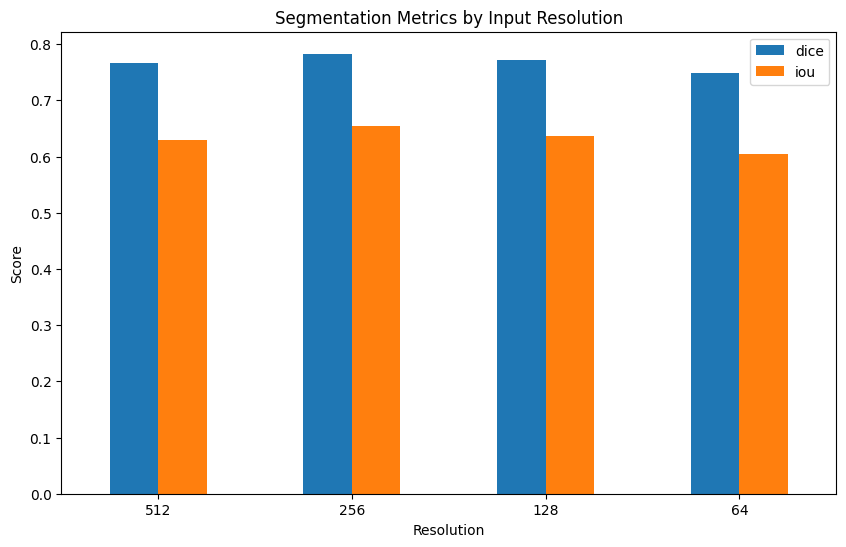

In [57]:
# ============================================================================\n
# DISPLAY RESULTS
# ============================================================================\n

# Convert results dictionary to a Pandas DataFrame
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.index.name = 'Resolution'
results_df = results_df.sort_index(ascending=False)

print("\n--- Final Experiment Results ---")
print(results_df)

# Optional: Plot the results
results_df.plot(kind='bar', y=['dice', 'iou'], 
                title='Segmentation Metrics by Input Resolution', 
                figsize=(10, 6))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()